# Mixed Signals - soil bioturbation simulation tool
Author: W. Marijn van der Meij<br>
Institute of geography, University of Cologne, Germany<br>
2024<br>
Version 1.0<br>
***
This Jupyter Notebook contains the code and examples for running the Mixed Signal model, a numerical model for simulating different bioturbation processes and their effect on luminescence tracers. The code is written in the Julia programming language.

The background, design and use cases of this model are described in the accompanying paper `Mixed signals: interpreting mixing patterns of different soil bioturbation processes through luminescence and numerical modelling`, by W.M. van der Meij, S. Riedesel and T Reimann (2024) [DOI]. This Jupyter Notebook will guide you through different uses of the model, which are the simulation of different bioturbation processes, process interactions, runs with varying parameters and the calibration of luminescence-based depth profiles. The required functions to run the model are stored in the file `Mixed-Signals_functions.jl`.

The simulated luminescence-based depth profiles are presented in three metrics:
- The modal age of the age distributions, as the most probable age of each layer
- The interquartile range, as a measure of the width of the distribution
- the bioturbated fraction, as a measure of the fraction of bleached (i.e. bioturbated) particles in each layer. 

# Table of Contents
* [1. Prepare workspace](#chapter1)
* [2. Define parameters](#chapter2)
* [3. Mounding](#chapter3)
* [4. Subsurface mixing](#chapter4)
* [5. Combination of mounding and subsurface mixing](#chapter5)
* [6. Varying parameters](#chapter6)
* [7. Calibration of luminescence-based depth profiles](#chapter7)
* [8. Read and load simulation data](#chapter8)

## 1. Prepare workspace <a class="anchor" id="chapter1"></a>
The functions for the simulations are stored in the `Mixed-signals_functions.jl` file. You can open this file separately to look at, or modify, the code. For using this notebook, you run the code below to load the functions and the required packages. This is required every time the Notebook is opened or restarted. The first time that you run this line will take a while, as all the required packages need to be installed. The packages will be installed in the project folder, where this notebook is also stored. The extension of these files is .toml. 

If you work in Visual Studio Code, the program might ask for a kernel, which refers to the modelling language the code is written in. Select Julia as kernel.  

In [37]:
include("Mixed-Signals_functions.jl")

#591 (generic function with 1 method)

## 2. Define parameters <a class="anchor" id="chapter2"></a>
In the code below, the parameters are defined. The first block contains the parameters for defining the soil and luminescence tracers. The second block contains the parameters that determine process behaviour. The soil profile is represented by a matrix with a specified number of soil layers. With the parameters below, the soil is 2 meters deep and initially contains 100 soil layers of 2 cm thick. The uppermost layer of 5 mm is the layer where particles are bleached and their burial ages are set to zero. Every layer initially contains 150 luminescence particles. Each layer has a constant bulk density of 1500 kg $m^{-3}$. 

Through the transfer of soil mass by soil mixing during the simulations, the soil layer thicknesses and their number of luminescence particles will change. When layers get too thin or too thick (55% more or less that the initial thickness), they are either merged with neighbouring layers or split into two separate layers. These dynamic layer thicknesses enable an accurate simulation of additions and removals in different parts of the soil profile. When splitting and merging, the luminescence particles will also be divided or combined. The luminescence particles are stored in an array of arrays, which are able to store variable numbers of luminescence particles for each layer. 

In [38]:
## Define objects and parameters for soil and luminescence
bd = 1500               # Bulk density [kg m⁻³]
soildepth = 2           # Thickness of the entire soil profile [m]
nlayers = 100           # Number of soil layers
layer_thickness = 0.02  # Initial layer thickness [m]
bleaching_depth = 0.005 # Thickness of surface layer where bleaching occurs [m]
grains_per_layer = 150  # Initial number of layers per soil layer

# Define process-specific parameters 
BT_pot = 10             # Potential bioturbation rate [kg m⁻² a⁻¹]
dd = 1                  # Depth parameter [m⁻¹]
dd_exch = 10            # Depth parameter for subsurface mixing [m⁻¹]
ntime = 10000           # Number of simulation years

10000

## 3. Mounding <a class="anchor" id="chapter3"></a>
The code cell below simulates the mounding process using the parameters set above. The first line of code creates the objects `soil` and `ages` using the function `initialise_soil`, using the parameters defined above. These objects are arrays that store the information on soil layer thickness and the luminescence tracers. It is adviced to create new matrices with unique names for each simulation run, to prevent overwriting previous results. Make sure that these new matrix names are referenced in all the functions in the code cell. See [Section 8](#chapter8) for functions to save and load simulation results.

The next part of the code iterates over the amount of timesteps. Every timestep, an event of mounding is simulated and the `soil` and `ages` objects are updated. `@showprogress` is a tool that adds a progress bar at the bottom of the code block to see how long the simulations will take.

The function `BT_mounding()` simulates the mounding process, with five arguments:
1. a `soil` matrix, created with `initialise_soil`
2. an `ages` matrix, created with `initialise_soil`
3. potential bioturbation rate `BT_pot`
4. depth function
5. depth parameter `dd` 

The options for the depth functions are:
- "grd: gradational or linearly decreasing rate with depth
- "exp": exponentially decreasing rate with depth
- "abr": uniform mixing rates in the active mixing zone, with an abrupt decrease to zero below.

The function `update_soil_and_luminescence()` updates soil properties and luminescence ages after each bioturbation run. This code updates layer thicknesses, adds a year to all luminescence ages and resets the ages of luminescence particles in the bleaching layer. Required inputs are `soil` and  `ages` objects. 

In [3]:
# Initialization function to create matrices for the simulations
soil_mounding, ages_mounding = initialise_soil(soildepth, nlayers, layer_thickness, bleaching_depth, grains_per_layer)

# iteration over the number of time steps
@showprogress dt=1 for t in 1:ntime
    # Mounding function 
    soil_mounding, ages_mounding = BT_mounding(soil_mounding, ages_mounding, BT_pot, "grd", dd)
    # Function to update layer thicknesses and luminescence ages
    soil_mounding, ages_mounding = update_soil_and_luminescence(soil_mounding, ages_mounding)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


The next code cell visualizes the simulated luminescence-based depth profiles. The particle transport is simulated as stochastic process, which can result in scattered dpeth profiles. The plotting function has a option to aggregate the ages of different layers to reduce this scatter and produce smoother layers. The plotting function required three arguments:<br>
1. a `soil` matrix
2. an `ages` matrix
3. a number indicating how many layers should be aggregated

In the code cell below, the results are aggregated for every 2 layers. The plot shows the modal ages, interquartile range (IQR) and the bioturbated fraction. The results will be slightly different for each model run, because the luminescence particle tracing is simulated as a stochastic process. Increasing the number of particles per layer will result in more robust results, but also required longer calculation times. 

The figures can be saved using the function `savefig()`. By removing the `#`, the code line is activated and will be executed. This function requires the object in which the figure is stored (in this case `fig_mounding`) and the directory where the figure needs to be stored. In this case the file will be stored in the working directory under the name `BT_mounding.png`. Figures can be saved in different formats, by changing the file extension in the directory name (e.g. *.pdf or *.png). Click [here](https://docs.juliaplots.org/latest/output/) for more information and options on saving figures.

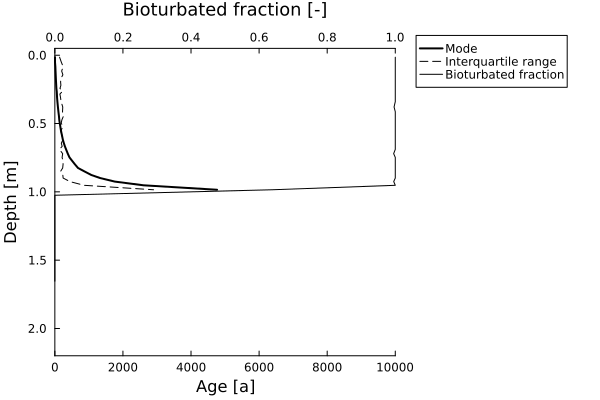

In [5]:
# Plotting function to create luminescence-based depth profiles with three arguments
fig_mounding = plot_age_depth_profile(soil_mounding, ages_mounding, 2)

# Function to save the figure
# savefig(fig_mounding,  "BT_mounding.png")

# Call the object that stores the figure to provide it as output of this code cell
fig_mounding

There are four optional parameters in the plotting function to modify the plot, which can be added after the first three parameters:<br>

4. a boolean where you can indicate if you want a curve of the interquartile range or if you want to visualize probability density functions of the luminescence particle ages for each layer. This parameter is set to `true` by default, to indicate the plotting of the IQR-curve. By changing it to `false`, the probability functions will be plotted. 
5. A number indicating for how many layers density functions need to be plotted. In the code below, for example, probability functions of every third layer will be plotted.
6. a customized range for the x-axis. This is by default a range from 0 to the number of calculation steps
7. a customized range for the y-axis. This is by default a range from -0.05 to 1.1 * the soil depth

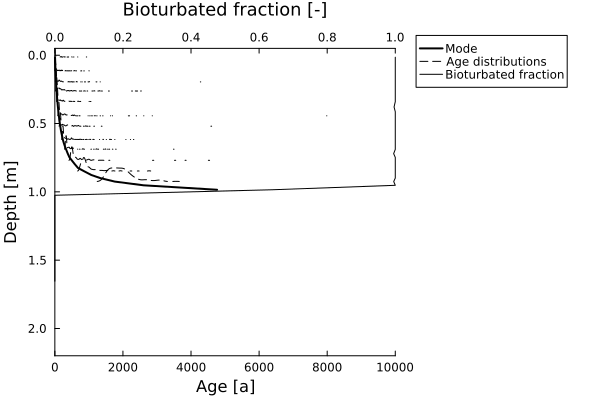

In [12]:
# Plotting function to create luminescence-based depth profiles with three required and four optional arguments
fig_mounding_2 = plot_age_depth_profile(soil_mounding, ages_mounding, 2, false, 3, [0, 10000], [-0.05, soildepth * 1.1])
fig_mounding_2

## 4. Subsurface mixing <a class="anchor" id="chapter4"></a>
Simulations with other bioturbation processes, such as subsurface mixing, follow the same syntax, only with a different function name: `BT_mixing()`. The arguments for this function are:<br>
1. a `soil` matrix, created with `initialise_soil`
2. an `ages` matrix, created with `initialise_soil`
3. potential bioturbation rate `BT_pot`
4. depth function
5. depth parameter `dd` 

The code below simulates subsurface mixing with an exponential depth profile and depth parameter of 6 m⁻¹. Subsurface mixing requires much more calculation time, because there is exchange of soil material between each individual layer. The number of layers in the soil profile determines the calculation time, which increases exponentially with the numbers of layers. 

In [7]:
# Initialization function to create matrices for the simulations
soil_mixing, ages_mixing = initialise_soil(soildepth, nlayers, layer_thickness, bleaching_depth, grains_per_layer)

# iteration over the number of time steps
@showprogress dt=1 for t in 1:ntime
    # Subsurface mixing function 
    soil_mixing, ages_mixing = BT_mixing(soil_mixing, ages_mixing, BT_pot, "exp", 6)
    # Function to update layer thicknesses and luminescence ages
    soil_mixing, ages_mixing = update_soil_and_luminescence(soil_mixing, ages_mixing)
end


Progress: 100%|█████████████████████████████████████████| Time: 0:06:41


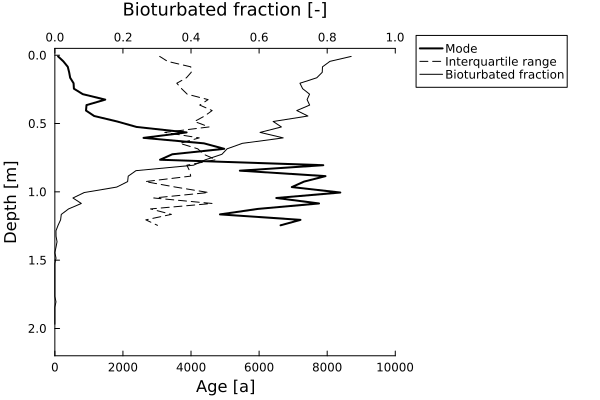

In [13]:
# Plotting function to create luminescence-based depth profiles
fig_subsurface_mixing = plot_age_depth_profile(soil_mixing, ages_mixing, 2)
fig_subsurface_mixing

## 5. Combination of mounding and subsurface mixing <a class="anchor" id="chapter5"></a>
Mixed Signals is also able to simulate mounding and subsurface mixing simultaneously. To do this, you can add both bioturbation processes in the iteration loop and optionally modify their bioturbation rates. The code below simulates both processes with a total bioturbation rate of `BT_pot`, with 25% mounding and 75% subsurface mixing. You can also provide absolute values for `BT_pot` for each of the processes. In the code cell below, both processes have the same gradational depth function and depth decay parameter `dd`.

In [14]:
# Initialization function to create matrices for the simulations
soil_multiple, ages_multiple = initialise_soil(soildepth, nlayers, layer_thickness, bleaching_depth, grains_per_layer)

# iteration over the number of time steps
@showprogress dt=5 for t in 1:ntime
    # Mounding and subsurface mixing functions
    soil_multiple, ages_multiple = BT_mounding(soil_multiple, ages_multiple, BT_pot * 0.25, "grd", dd)
    soil_multiple, ages_multiple = BT_mixing(soil_multiple, ages_multiple, BT_pot * 0.75, "grd", dd)
    # Function to update layer thicknesses and luminescence ages
    soil_multiple, ages_multiple = update_soil_and_luminescence(soil_multiple, ages_multiple)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:05:15


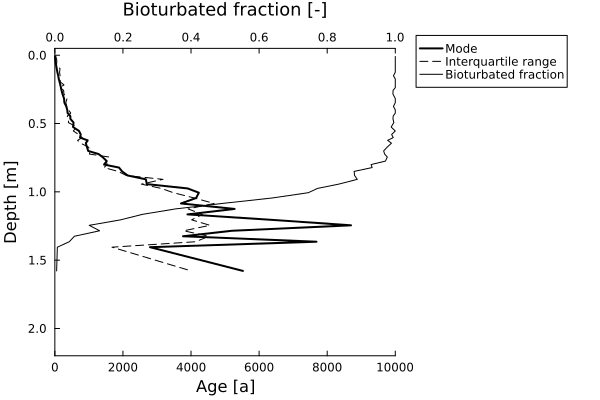

In [15]:
# Plotting function to create luminescence-based depth profiles
fig_multiple = plot_age_depth_profile(soil_multiple, ages_multiple, 2)
fig_multiple

## 6. Varying parameters <a class="anchor" id="chapter6"></a>
The code below can be used to compare simulations with varying parameter settings. These parameter settings are stored in vectors, in this case indicating different depth functions in the vector `depthfunctions` and their corresponding depth decay parameters in `depthdecayparameters`. All input of the bioturbation functions can be varied. The variations need to be stored in vectors. If there are multiple parameters varied, make sure that each vector has the same length. In the bioturbation run, index the respective vector for the parameter of choice. 

Multi-dimensional arrays are required to store the outputs of the different simulation scenarios. The first dimension is the number of variations, defined by `length(depthfunctions)` in the code below. The other two dimensions are the same as for a normal simulation run: the number of soil layers `nlayers` and four columns for the output array for the multi-dimensional soil array `soil_depthfunction`. The last dimension of the multi-dimensional array `ages_depthfunction` depends on the number of luminescence particles in the simulated profiles and will be defined after the simulations.  

In [17]:
# Define the variations in the parameters. Make sure that the depth decay parameters match the depth functions, and that both vectors are of the same length
depthfunctions = ["grd", "exp", "abr"]
depthdecayparameters = [1, 6, 1]

# Create empty, multi-dimensional arrays to store the outputs from the simulations
soil_depthfunction = zeros(Float64, (length(depthfunctions), nlayers, 4))
ages_depthfunction = fill(Int[],(length(depthfunctions), nlayers))

# Iterate over the varying depth functions and run the simulations
for i in eachindex(depthfunctions)
    # Initialization function to create matrices necessary for the simulations
    soil, ages = initialise_soil(soildepth, nlayers, layer_thickness, bleaching_depth, grains_per_layer)
    @showprogress dt=1 for t in 1:ntime
        # Mounding function with five arguments
        soil, ages = BT_mounding(soil, ages, BT_pot, depthfunctions[i], depthdecayparameters[i])
        # Function to update layer thicknesses and luminescence ages
        soil, ages = update_soil_and_luminescence(soil, ages)
    end
    # Store the results from the simulation scenario to a unique position in the multi-dimensional arrays
    soil_depthfunction[i,:,:] = soil
    ages_depthfunction[i,:,:] = ages
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


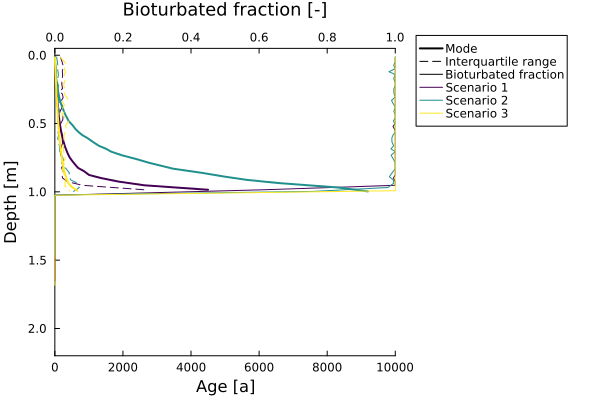

In [18]:

# The plotting works the same as for single simulations. Add the multi-dimensional arrays as soil and ages objects. The different scenarios are indicated with different colors in the final plot
fig_varyingParameters = plot_age_depth_profile(soil_depthfunction, ages_depthfunction, 2)
fig_varyingParameters

## 7. Calibration of luminescence-based depth profiles <a class="anchor" id="chapter7"></a>
Calibration of luminescence-based depth curves requires three steps:<br>
1. Prepare the calibration data and define the calibration parameters
2. Run the calibration scenarios and calculate the corresponding errors
3. Define the scenario with the lowest error, re-run that scenario and plot the results<br>

### 7.1 Prepare calibration data and parameters
The data needed for the calibration should be prepared in a CVS file, which contains measurements from all samples from a sampled soil profile. Measurements from different samples are placed below each other. The depth of each sample is used to separate between the different samples. The CSV file should contain three columns with the following information. Make sure that the columns in the CSV have the same names as the variables described below, all without capitals:
- depth: depth of every sample, in meters. This parameter is used to separate the different samples
- fbio: bioturbated fraction, or non-saturated fraction, value between 0 and 1
- age: age of the individual De measurements, in years

As example, we provided a synthetic dataset for the calibration with the model, named `synthetic_calibration_data.csv`. This dataset is used below to illustrate how the calibration works. It contains five sampling depths, with each 150 age observations. The dataset is created by randomly sampling ages for each depth from a normal distribution and adding a noise component. The data do not represent any real-life bioturbation dataset and only serves an illustrative purpose. 

In [39]:
# Read the CSV file containing the calibration data. 
calibration_data = CSV.read("synthetic_calibration_data.csv", DataFrame)

Row,depth,fbio,age
,Float64,Float64,Float64
1,0.1,0.87,-554.0
2,0.1,0.87,470.45
3,0.1,0.87,624.62
4,0.1,0.87,486.7
5,0.1,0.87,-105.93
6,0.1,0.87,1226.66
7,0.1,0.87,371.28
8,0.1,0.87,-359.82
9,0.1,0.87,-1558.53


After that, the parameters that require calibration should be specified. The model can calibrate all parameters of the bioturbation functions. Below, all parameters of the calibration runs are defined. For the parameters that need to be calibrated, multiple values are provided. These can be provided in a vector, for example the different depth functions in `cal_depthfunction`: `["grd", "exp", "abr"]`. Another option is to define a range with a certain step size, for example for the `cal_BT_pot`: a range starting from 0.5, with a step of 0.5 up to a value of 3: `1:0.5:3`. Parameters that don't require calibration should be provided a single value. The function `create_calibration_parameters()` will create a table with all unique combinations of the calibration parameters, which serves as input for the different calibration runs. 

I advice to use larger step sizes between the different values for a first calibration run and zoom in on the parameter set with the lowest calibration score for a second calibration run, using smaller step sizes. This will reduce the number of calculation steps. 

In [52]:

# Define the variation in the input parameters
cal_depthfunction = ["grd", "exp", "abr"] # Depth functions. Vector with different values
cal_BT_pot = 1:0.5:3  # Bioturbation rate. Range of values, from 1 with increments of 0.5 up to 3
cal_active_mixing_depth = 1 # Single value. This parameter indications the thickness of the active mixing zone. The corresponding depth decay parameters will be calculated in the create_calibration_parameters() function based on the respective depth function
cal_rel_process = 0:.2:1 # Ratio between mounding and subsurface miing. Range of values, ranging from 0 (only subsirface mixing) to 1 (only mounding), with increments of 0.2. 

# Create matrix with all unique combinations of the calibration parameters
calib_parameters_and_results = create_calibration_parameters(cal_depthfunction, cal_BT_pot, cal_active_mixing_depth, cal_rel_process)

# Print the number of calibration scenarios
n_scen = length(cal_depthfunction)*length(cal_BT_pot)*length(cal_active_mixing_depth)*length(cal_rel_process)
print(string("Number of calibration runs: ", n_scen))

Number of calibration runs: 90

Now the soil- and luminescence-related parameters for the calibration runs need to be defined. These parameters determine the number of soil layers, and with that, the calculation time. A lower number of layers, with corresponding higher thicknesses will reduce the calculation times substantially. The calibration calculations are performed in parallel, using all the cores on your computer. This will decrease the calculation time, but will also limit the use of your computer for other tasks. Count on several hours of calculation time. The progress bar will appear after a few minutes and give an indication of the remaining time. The parameters below simulate a soil profile with a `soildepth` of 1.5 m, 50 layers of 3 cm thick and initially 150 `grains_per_layer`. The runtime is 5000 years.

In [5]:
# Set parameters for the calibration run. These parameters are equal for all the simulations
ntime = 100            # runtime of the model
bd = 1500               # Bulk density [kg m-3]
soildepth = 1.5         # Thickness of the entire soil profile [m]
nlayers = 50            # Number of soil layers
layer_thickness = 0.03  # Initial layer thickness [m]
bleaching_depth = 0.005 # Thickness of surface layer where bleaching occurs [m]
grains_per_layer = 150  # Initial number of layers per soil layer
dd_exch = 10            # Depth parameter for subsurface mixing [m-1]

soil_age_parameters = [ntime, soildepth, nlayers, layer_thickness, bleaching_depth, grains_per_layer, bd, dd_exch]

8-element Vector{Float64}:
  100.0
    1.5
   50.0
    0.03
    0.005
  150.0
 1500.0
   10.0

### 7.2 Run the calibration scenarios
Now it's time to run the calibration scenarios. The function `BT_calibration_run` contains all required initialisation, bioturbation and update functions. The results are a soil `s` and ages `a` array containing the results of that specific scenario. These are used to calculate the calibration error with the function `BT_calibration_errors`. The required inputs are the soil `s` and ages `a` arrays and the `calibration_data`. 

Th function can calibrate on three metrics: the mode of the age distributions, the interquartile range of the age distributions and the bioturbated fraction. For each metric, the squared error is calculated. The calibration metrics can be included or excluded by switching the `true` to `false` in the calibration function in the code below. These  boolean operators for the different metrics are in the following order: mode, interquartile range, bioturbated fraction.

In [16]:
#rmprocs(workers())
using Distributed
nprocs()
rmprocs(workers())
nprocs()

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed C:\Users\Marijn\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\cluster.jl:1049


1

In [67]:
# Run the calibration scenarios
n_cores = Sys.CPU_THREADS
rmprocs(workers())
addprocs(n_cores - 2)
print("Calibration will run on ", string(nprocs()), " processors")

@everywhere include("Mixed-Signals_functions.jl")
calib_parameters_and_results = create_calibration_parameters(cal_depthfunction, cal_BT_pot, cal_active_mixing_depth, cal_rel_process)
calib_parameters_and_results = SharedArray(calib_parameters_and_results)


Calibration will run on 11 processors

90×8 SharedMatrix{Float64}:
 1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.2  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.4  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.6  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.8  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.5  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.5  1.0  0.2  0.0  0.0  0.0  0.0
 1.0  1.5  1.0  0.4  0.0  0.0  0.0  0.0
 1.0  1.5  1.0  0.6  0.0  0.0  0.0  0.0
 ⋮                        ⋮         
 3.0  2.5  1.0  0.6  0.0  0.0  0.0  0.0
 3.0  2.5  1.0  0.8  0.0  0.0  0.0  0.0
 3.0  2.5  1.0  1.0  0.0  0.0  0.0  0.0
 3.0  3.0  1.0  0.0  0.0  0.0  0.0  0.0
 3.0  3.0  1.0  0.2  0.0  0.0  0.0  0.0
 3.0  3.0  1.0  0.4  0.0  0.0  0.0  0.0
 3.0  3.0  1.0  0.6  0.0  0.0  0.0  0.0
 3.0  3.0  1.0  0.8  0.0  0.0  0.0  0.0
 3.0  3.0  1.0  1.0  0.0  0.0  0.0  0.0

In [69]:

# Calibration functions
@sync @distributed for i in (1:n_scen)
    s, a = BT_calibration_run(soil_age_parameters, calib_parameters_and_results, i) # Calculate bioturbation scenario
    #calib_parameters_and_results[i,5:8] .= BT_calibration_errors(s, a, calibration_data, true, true, true) # calculate calibration error
end

rmprocs(workers())


Unhandled Task ERROR: On worker 105:
BoundsError: attempt to access 50×4 Matrix{Float64} at index [1:100, 1]
Stacktrace:
  [1] throw_boundserror
    @ .\abstractarray.jl:737
  [2] checkbounds
    @ .\abstractarray.jl:702 [inlined]
  [3] _getindex
    @ .\multidimensional.jl:888 [inlined]
  [4] getindex
    @ .\abstractarray.jl:1291
  [5] #921
    @ c:\Users\Marijn\sciebo\Research\Bioturbation\Mixed-signals_Bioturbation\Mixed-Signals_functions.jl:287
  [6] #915
    @ c:\Users\Marijn\sciebo\Research\Bioturbation\Mixed-signals_Bioturbation\Mixed-Signals_functions.jl:172
  [7] #925
    @ c:\Users\Marijn\sciebo\Research\Bioturbation\Mixed-signals_Bioturbation\Mixed-Signals_functions.jl:364
  [8] macro expansion
    @ c:\Users\Marijn\sciebo\Research\Bioturbation\Mixed-signals_Bioturbation\Mixed-Signals.ipynb:4 [inlined]
  [9] #953
    @ C:\Users\Marijn\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\macros.jl:303
 [10] #178
    @ C:\Users\Marijn\.julia\

CompositeException: TaskFailedException

    nested task error: On worker 105:
    BoundsError: attempt to access 50×4 Matrix{Float64} at index [1:100, 1]
    Stacktrace:
      [1] throw_boundserror
        @ .\abstractarray.jl:737
      [2] checkbounds
        @ .\abstractarray.jl:702 [inlined]
      [3] _getindex
        @ .\multidimensional.jl:888 [inlined]
      [4] getindex
        @ .\abstractarray.jl:1291
      [5] #921
        @ c:\Users\Marijn\sciebo\Research\Bioturbation\Mixed-signals_Bioturbation\Mixed-Signals_functions.jl:287
      [6] #915
        @ c:\Users\Marijn\sciebo\Research\Bioturbation\Mixed-signals_Bioturbation\Mixed-Signals_functions.jl:172
      [7] #925
        @ c:\Users\Marijn\sciebo\Research\Bioturbation\Mixed-signals_Bioturbation\Mixed-Signals_functions.jl:364
      [8] macro expansion
        @ c:\Users\Marijn\sciebo\Research\Bioturbation\Mixed-signals_Bioturbation\Mixed-Signals.ipynb:4 [inlined]
      [9] #953
        @ C:\Users\Marijn\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\macros.jl:303
     [10] #178
        @ C:\Users\Marijn\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\macros.jl:83
     [11] #invokelatest#2
        @ .\essentials.jl:892 [inlined]
     [12] invokelatest
        @ .\essentials.jl:889
     [13] #107
        @ C:\Users\Marijn\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\process_messages.jl:283
     [14] run_work_thunk
        @ C:\Users\Marijn\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\process_messages.jl:70
     [15] run_work_thunk
        @ C:\Users\Marijn\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\process_messages.jl:79
     [16] #100
        @ C:\Users\Marijn\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\process_messages.jl:88
    
    ...and 9 more exceptions.
    
    Stacktrace:
     [1] sync_end(c::Channel{Any})
       @ Base .\task.jl:448
     [2] macro expansion
       @ .\task.jl:480 [inlined]
     [3] (::Distributed.var"#177#179"{var"#953#954", UnitRange{Int64}})()
       @ Distributed C:\Users\Marijn\.julia\juliaup\julia-1.10.2+0.x64.w64.mingw32\share\julia\stdlib\v1.10\Distributed\src\macros.jl:278

In [15]:
calib_parameters_and_results

90×8 Matrix{Float64}:
 1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.2  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.4  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.6  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.8  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.5  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.5  1.0  0.2  0.0  0.0  0.0  0.0
 1.0  1.5  1.0  0.4  0.0  0.0  0.0  0.0
 1.0  1.5  1.0  0.6  0.0  0.0  0.0  0.0
 ⋮                        ⋮         
 3.0  2.5  1.0  0.6  0.0  0.0  0.0  0.0
 3.0  2.5  1.0  0.8  0.0  0.0  0.0  0.0
 3.0  2.5  1.0  1.0  0.0  0.0  0.0  0.0
 3.0  3.0  1.0  0.0  0.0  0.0  0.0  0.0
 3.0  3.0  1.0  0.2  0.0  0.0  0.0  0.0
 3.0  3.0  1.0  0.4  0.0  0.0  0.0  0.0
 3.0  3.0  1.0  0.6  0.0  0.0  0.0  0.0
 3.0  3.0  1.0  0.8  0.0  0.0  0.0  0.0
 3.0  3.0  1.0  1.0  0.0  0.0  0.0  0.0

First, we visualize the calibration error curve. 

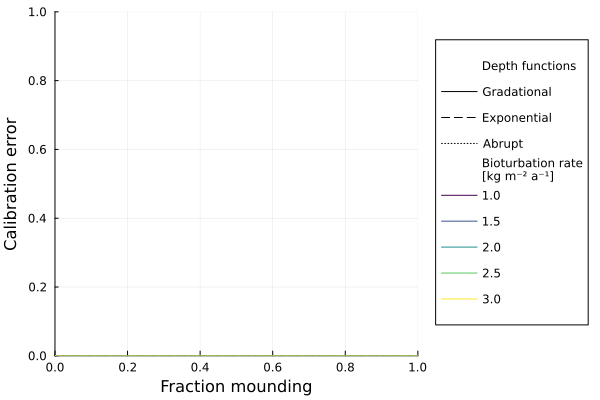

In [9]:
fig_calibrationcurve = plot_calibration_curves(calib_parameters_and_results)
fig_calibrationcurve

Finally, we re-run the best scoring calibration scenario and plot the results with the experimental data. The first code block prints out the parameters of the best performing calibration scenario. The second code block re-runs the best performing scenario and plots the experimental and simulated luminescence-based depth curves.

In [16]:
# Identify run with best parameter, based on the total error
y=calib_parameters_and_results[:,8]
index_calibration = findall(y .== minimum(y))[1]
depthfunctions = ["Gradational", "Exponential", "Abrupt"]

# Print the best calibration parameters
string("Depth function: ", depthfunctions[Int(calib_parameters_and_results[index_calibration,1])],". Bioturbation rate: ", calib_parameters_and_results[index_calibration,2]," kg m⁻² a⁻¹. Percentage mounding: ", calib_parameters_and_results[index_calibration,4]*100, "%")

"Depth function: Gradational. Bioturbation rate: 3.0 kg m⁻² a⁻¹. Percentage mounding: 20.0%"

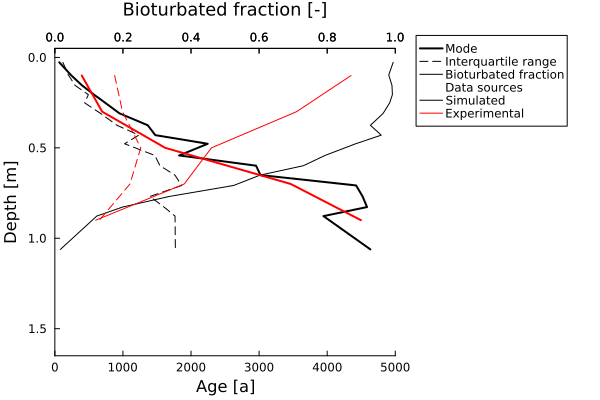

In [8]:
# Re-run the scenario with the lowest error and plot the results with the experimental data
soil_calibration, ages_calibration = BT_calibration_run(soil_age_parameters, calib_parameters_and_results, index_calibration)

# Plot the experimental and simulated luminescence-based depth curves
fig_calibration = plot_age_depth_profile(soil_calibration, ages_calibration, 3)
fig_calibration = add_calibration_PDFs(fig_calibration, calibration_data)
fig_calibration

## 8. Save and load model output <a class="anchor" id="chapter8"></a>
Every simulation run will output an array with information on the layer thicknesses and an array of arrays with the ages of the luminescence particles. These objects can be stored as specific Julia objects with the extension `JLD2` with the function `write_soil_and_age_JLD2()`, which can later be reloaded for further analysis with the function `read_soil_and_age_JLD2()`. The simulation results can also be exported as a .csv file for analysis in other software, with the function `write_soil_and_age_CSV()`. These CSVs can be reloaded into the soil and age arrays with the function `read_soil_and_age_CSV()`. The required inputs are the soil and ages arrays, a name of the simulated scenario, which will be added to the file name, and an optional folder name or directory where the files need to be stored. If this is unspecified, the files will be stored in the folder where this notebook is stored. 

For the read functions, the directories to the soil and ages files need to be provided. These lines are now commented to avoid reading data files that do not exist. In order to run these lines, remove the # symbol and provide directories to the desired files. 

In [ ]:
# Export simulation results as CSV
write_soil_ages_CSV(soil_mounding, ages_mounding, "scenario_name", "folder_name")

# Import simulation results as CSV
# soil, ages = read_soil_ages_CSV("directory_of_soil_file.csv", "directory_of_ages_file.csv")

# Save simulation results as JLD2 file
write_soil_ages_JLD2(soil_mounding, ages_mounding, "scenario_name", "folder_name")

# Load simulation results stored as JLD2 file
# soil, ages = read_soil_ages_JLD2("directory_of_soil_file.csv", "directory_of_ages_file.csv")

UndefVarError: UndefVarError: `write_soil_ages_CSV` not defined